In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

def plot_distribution_summary(data, title="Distribution Summary"):
    # Compute statistics
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    skew = stats.skew(data)
    kurt = stats.kurtosis(data, fisher=True)
    ks_stat, _ = stats.kstest(data, 'norm', args=(mean, std))

    # Set up the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title.upper(), fontsize=14)

    # KDE plot
    sns.kdeplot(data, ax=axes[0], color='gray', fill=True)
    axes[0].set_title("Kernel Density")
    axes[0].grid(True, linestyle='--', alpha=0.3)
    axes[0].tick_params(labelsize=10)


    # QQ plot
    stats.probplot(data, dist="norm", sparams=(mean, std), plot=axes[1])
    axes[1].get_lines()[1].set_color("black")  # QQ reference line
    axes[1].get_lines()[0].set_markerfacecolor("gray")  # Sample points
    axes[1].get_lines()[0].set_markeredgecolor("gray")
    axes[1].set_title("QQ Plot (Normal)")
    axes[1].grid(True, linestyle='--', alpha=0.3)
    axes[1].tick_params(labelsize=10)
    for label in axes[1].get_xticklabels() + axes[1].get_yticklabels():
        label.set_fontname("Courier New")

    # Text box with stats
    stats_text = (
        f"Mean: {mean:.2f}    SD: {std:.2f}    "
        f"Skew: {skew:.2f}    Kurtosis: {kurt:.2f}    "
        f"KS Stat: {ks_stat:.3f}"
    )
    fig.text(0.5, 0.02, stats_text, ha='center', fontsize=11)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

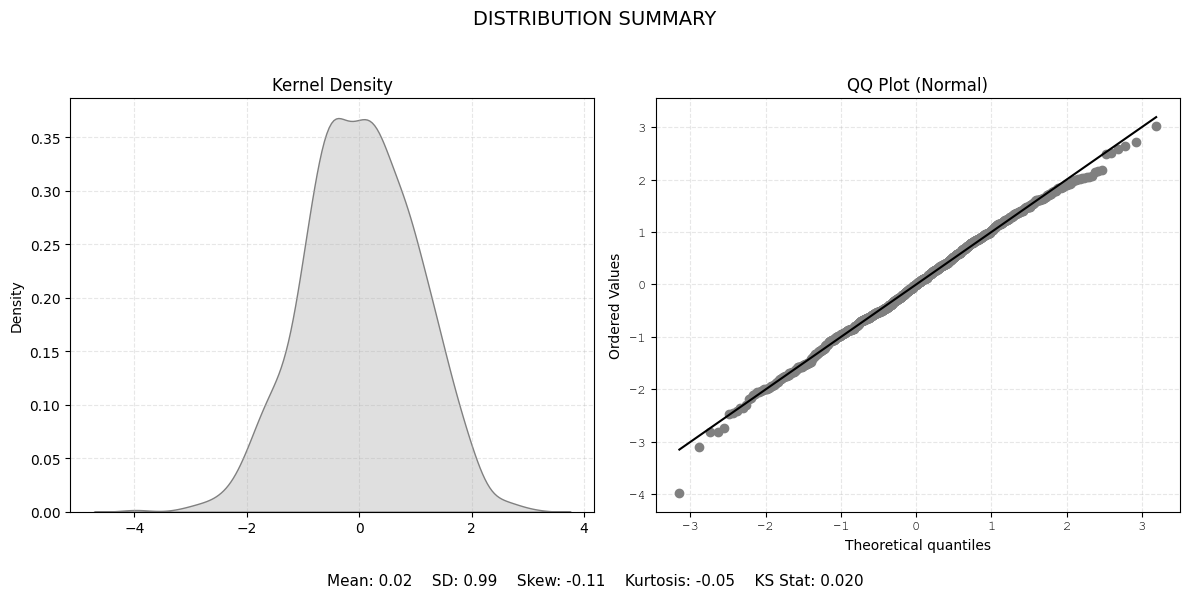

In [8]:
import numpy as np
sample_data = np.random.normal(0, 1, size=1000)
plot_distribution_summary(sample_data)


In [24]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np
from datetime import datetime
import pandas as pd
def plot_annotated_returns(df: pl.DataFrame, date_col: str = "Month", return_col: str = "Return"):
    # Convert date strings to datetime


    # Compute basic stats
    returns = df[return_col].to_numpy()
    dates = df[date_col].to_numpy()
    mean = returns.mean()
    std = returns.std()

    # Set up plot
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, returns, marker='o', linestyle='-', color='gray', label="Monthly Return")

    # Add horizontal lines for mean and ±1, ±2 std
    for i in [-2, -1, 1, 2]:
        ax.axhline(mean + i * std, color='black', linestyle='--', alpha=0.2)

    # Annotate events with large drops
    for date, ret in zip(dates, returns):
        if ret < mean - 1.5 * std:
            label = f"{pd.to_datetime(str(date)).strftime('%b %Y')}\n{ret:.2%} ({(ret - mean)/std:.1f}σ)"

            ax.annotate(label,
                        xy=(date, ret),
                        xytext=(date, ret - 0.05),
                        textcoords='data',
                        ha='center',
                        fontsize=9,
                        fontname='Courier New',
                        arrowprops=dict(arrowstyle='->', color='black', lw=0.8))

    ax.set_title("Time Series of Monthly Returns", fontname='Courier New')
    ax.set_ylabel("Return", fontname='Courier New')
    ax.set_xlabel("Date", fontname='Courier New')
    ax.grid(True, linestyle='--', alpha=0.3)
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontname("Courier New")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [44]:
from scipy import stats, optimize
import numpy as np

def mle_t_degrees_of_freedom(returns: np.ndarray) -> float:
    """
    Returns the MLE estimate of degrees of freedom (ν) for a t-distribution.
    Assumes location and scale are also estimated.
    """
    returns = np.asarray(returns)

    def neg_log_likelihood(df):
        if df is None or df <= 2:  # enforce finite variance
            return np.inf
        _, loc, scale = stats.t.fit(returns, fdf=df)
        return -np.sum(stats.t.logpdf(returns, df, loc=loc, scale=scale))

    result = optimize.minimize_scalar(neg_log_likelihood, bounds=(2.01, 100), method="bounded")
    return result.x if result.success else np.nan


In [45]:
sample_returns = np.random.standard_t(df=5, size=1000)
estimated_df = mle_t_degrees_of_freedom(sample_returns)
print(f"Estimated degrees of freedom: {estimated_df:.2f}")


Estimated degrees of freedom: 5.29


In [47]:
def plot_distribution_summary_T(data, title="Distribution Summary"):
    # Fit t-distribution
    df_hat = mle_t_degrees_of_freedom(data)
    df_hat = float(df_hat)
    _, loc, scale = stats.t.fit(data, fdf=df_hat)
    
    # Compute stats
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    skew = stats.skew(data)
    kurt = stats.kurtosis(data, fisher=True)
    ks_stat, _ = stats.kstest(data, 't', args=(df_hat, loc, scale))

    # Set up the plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    plt.suptitle(title.upper(), fontsize=14)

    # KDE plot
    sns.kdeplot(data, ax=axes[0], color='gray', fill=True)
    axes[0].set_title("Kernel Density")
    axes[0].grid(True, linestyle='--', alpha=0.3)
    axes[0].tick_params(labelsize=10)

    # QQ plot (vs t-distribution)
    stats.probplot(data, dist="t", sparams=(df_hat, loc, scale), plot=axes[1])
    axes[1].get_lines()[1].set_color("black")
    axes[1].get_lines()[0].set_markerfacecolor("gray")
    axes[1].get_lines()[0].set_markeredgecolor("gray")
    axes[1].set_title(f"QQ Plot (t, df={df_hat:.1f})")
    axes[1].grid(True, linestyle='--', alpha=0.3)
    axes[1].tick_params(labelsize=10)

    # Text box with stats
    stats_text = (
        f"Mean: {mean:.2f}    SD: {std:.2f}    "
        f"Skew: {skew:.2f}    Kurtosis: {kurt:.2f}    "
        f"KS Stat: {ks_stat:.3f}"
    )
    fig.text(0.5, 0.02, stats_text, ha='center', fontsize=11)

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.show()

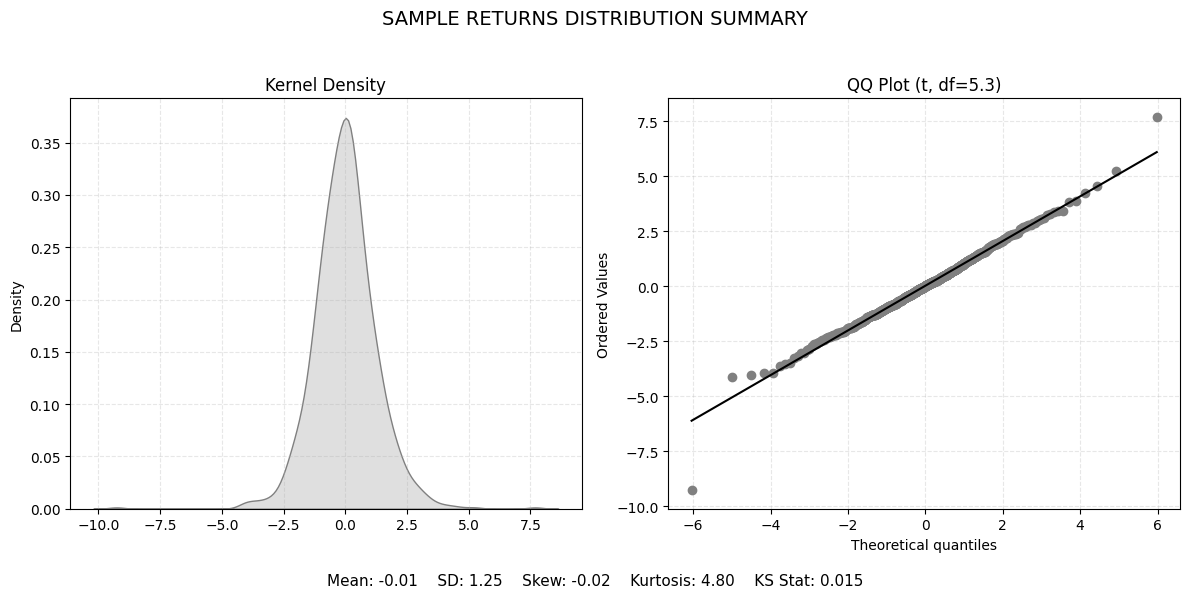

In [48]:
plot_distribution_summary(sample_returns, title="Sample Returns Distribution Summary")

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import wraps
from scipy.stats import norm, t

# --- Decorator to inject quantile function based on distribution ---
def quantile_provider(dist_type='normal', df=None):
    def decorator(func):
        @wraps(func)
        def wrapper(*args, **kwargs):
            if dist_type == 'normal':
                qfun = lambda p: norm.ppf(p)
            elif dist_type == 't':
                if df is None or df <= 2:
                    raise ValueError("Degrees of freedom (df) must be > 2 for t-distribution.")
                qfun = lambda p: t.ppf(p, df)
            else:
                raise ValueError("dist_type must be 'normal' or 't'")
            return func(*args, **kwargs, q=qfun)
        return wrapper
    return decorator

# --- Main plotting function ---
@quantile_provider(dist_type='t', df=5)  # change to 'normal' if desired
def plot_return_with_conf_band(dates, ret, rf_ret, beta, resid_std, q, title="Return with Confidence Band"):
    expected = beta * np.array(rf_ret)
    lower = expected + q(0.05) * resid_std
    upper = expected + q(0.975) * resid_std

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, ret, color='black', label='Actual Return')
    ax.plot(dates, expected, color='blue', linestyle='--', label='Expected (β·RF)')
    ax.fill_between(dates, lower, upper, color='red', alpha=0.1, label='CI Band')

    ax.set_title(title)
    ax.set_ylabel("Return")
    ax.set_xlabel("Date")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


C:\Users\kumar\AppData\Local\Temp\ipykernel_22088\2863358371.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=44, freq='M')


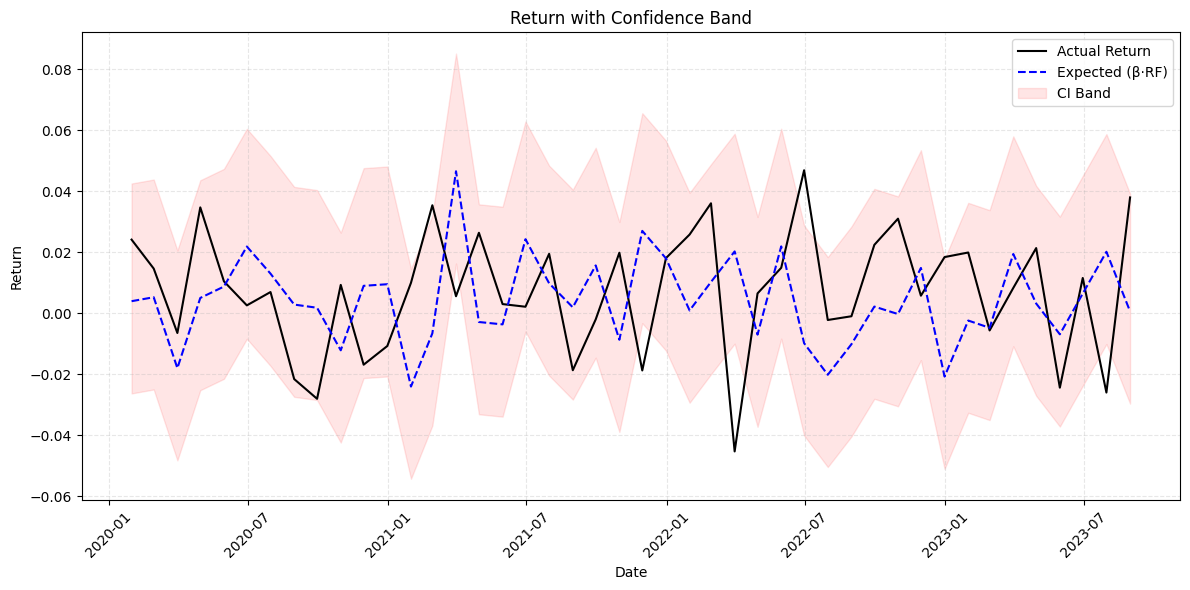

In [53]:
dates = pd.date_range(start='2020-01-01', periods=44, freq='M')
actual_returns = np.random.normal(0.01, 0.02, size=44)
rf_returns = np.random.normal(0.005, 0.01, size=44)
plot_return_with_conf_band(dates, actual_returns, rf_returns, beta=1.2, resid_std=0.015)
